In [20]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from tqdm import tqdm
from src import distributions
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")  # or "darkgrid", "ticks", etc.
sns.set_palette("flare")  # "mako", "rocket", "flare", etc.

In [21]:
inner_iters = 1000
batch_size = 256
vocab_size = 128
T = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
X_sampler = distributions.SwissRollSampler_discrete(device=device)
Y_sampler = distributions.Mix8GaussiansSampler_discrete(std=0.1, r=np.sqrt(2), device=device)

def sampler_0(batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_end = X_sampler.sample(batch_size)
    # x_end = torch.randint(0, 128, x_end.shape)
    return x_end.long()

def sampler_1(batch_size: int = 200, device: str = "cpu") -> Tensor:
    x_end = Y_sampler.sample(batch_size)
    # x_end = torch.randint(0, 128, x_end.shape)
    return x_end.long()

In [23]:
# def sampler_0(batch_size: int = 200, device: str = "cpu") -> Tensor:
#     x = torch.randint(low=0, high=vocab_size, size=(batch_size, 2), device=device)
#     x[:, 1]=vocab_size-1
#     # x_end = torch.randint(0, 128, x_end.shape)
#     return x.to(device).long()

# def sampler_1(batch_size: int = 200, device: str = "cpu") -> Tensor:
#     x = torch.randint(low=0, high=vocab_size, size=(batch_size, 2), device=device)
#     x[:, 1]=0
#     # x_end = torch.randint(0, 128, x_end.shape)
#     return x.to(device).long()

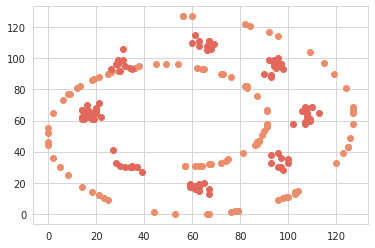

In [24]:
data = sampler_0(100)
plt.scatter(data[:, 0].cpu(), data[:, 1].cpu())
data = sampler_1(100)
plt.scatter(data[:, 0].cpu(), data[:, 1].cpu())

In [25]:
class DiscreteFlow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 128, v: int = 128):
        super().__init__()
        self.v = v
        self.embed = nn.Embedding(v, h)
        self.net = nn.Sequential(
            nn.Linear(dim * h + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim * v))
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t[:, None], self.embed(x_t).flatten(1, 2)), -1)).reshape(list(x_t.shape) + [self.v])

# Training

In [26]:
model_f = DiscreteFlow(v=vocab_size).to(device)
optim_f = torch.optim.Adam(model_f.parameters(), lr=1e-3)

model_b = DiscreteFlow(v=vocab_size).to(device)
optim_b = torch.optim.Adam(model_b.parameters(), lr=1e-3)

In [27]:
def train_with_data(model, optim, type='f'):
    # for iter in tqdm(range(inner_iters)):
    for iter in range(inner_iters):
        t = torch.rand(batch_size).to(device)
        if type=='f':
            x_1 = sampler_1(batch_size, device)
            x_0 = sampler_0(batch_size, device)
            x_t = torch.where(torch.rand(batch_size, 2).to(device) <  t[:, None], x_1, x_0)
        else:
            x_0 = sampler_0(batch_size, device)
            x_1 = sampler_1(batch_size, device)
            x_t = torch.where(torch.rand(batch_size, 2).to(device) <  t[:, None], x_0, x_1)
        

        logits = model(x_t, t)
        
        if type=='f':
            loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_1.flatten(0, 1)).mean()
        else:
            loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_0.flatten(0, 1)).mean()
            
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if iter%100==0:
            print(loss.item())

In [28]:
def sample_from_model(x, sample_model, batch_size):
    N = batch_size

    x_t = x
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-4:
        p1 = torch.softmax(sample_model(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))

    x_1 = results[-1][0]
    
    return x_1

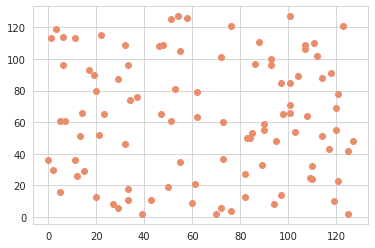

In [29]:
data = sampler_0(100, device)
data = sample_from_model(data, model_f, 100)
plt.scatter(data[:, 0].cpu(), data[:, 1].cpu())
# data = sampler_1(100, device)
# data = sample_from_model(data, model_b, 100).cpu()
# plt.scatter(data[:, 0], data[:, 1])

In [30]:
def train_with_model(model, optim, sample_model, type='f'):
    # for iter in tqdm(range(inner_iters)):
    for iter in range(inner_iters):
        t = torch.rand(batch_size).to(device)
        if type=='f':
            x_1 = sampler_1(batch_size, device)
            x_0 = sample_from_model(x_1, sample_model, batch_size)
            x_t = torch.where(torch.rand(batch_size, 2).to(device) <  t[:, None], x_1, x_0)
        else:
            x_0 = sampler_0(batch_size, device)
            x_1 = sample_from_model(x_0, sample_model, batch_size)
            x_t = torch.where(torch.rand(batch_size, 2).to(device) <  t[:, None], x_0, x_1)
        

        logits = model(x_t, t)
        
        if type=='f':
            loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_1.flatten(0, 1)).mean()
        else:
            loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_0.flatten(0, 1)).mean()
            
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if iter%100==0:
            print(loss.item())

In [31]:
# train_with_data(model_b, optim_b, 'b')

In [32]:
# train_with_data(model_f, optim_f, 'f')

# Sampling

In [33]:
def cost(results):
    costs = 0
    for i in range(len(results)-1):
        costs += (results[i][0] != results[i+1][0]).float().mean()
    
    return costs

In [43]:
def visualize(sampler, model):
    N = 1000

    x_t = sampler(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-4:
        p1 = torch.softmax(model(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))

    x_1 = results[-1][0]

    fig, axes = plt.subplots(1, len(results[::20]), figsize=(15, 3), sharex=True, sharey=True)

    for (x_t, t), ax in zip(results[::20], axes):
            # ax.scatter(x_t.detach().cpu()[:, 0], x_t.detach().cpu()[:, 1], s=10)
            # ax.set_title(f't={t:.1f}')
        sns.scatterplot(
            x=x_t.cpu().detach()[:, 0], 
            y=x_t.cpu().detach()[:, 1], 
            ax=ax,
            s=30,
            alpha=0.8,
            edgecolor="w",
            linewidth=0.5
        )

        # --- Properly remove ticks and labels ---
        ax.set_xticks([])  # Removes x-ticks (no 'None' issue)
        ax.set_yticks([])  # Removes y-ticks
        ax.set_xlabel("")  # Ensures no x-label
        ax.set_ylabel("")  # Ensures no y-label

        # Minimalist title
        ax.set_title(f"t = {t:.1f}", fontsize=10, pad=8)

    plt.tight_layout()
    plt.show()
    print('OT cost:', cost(results))

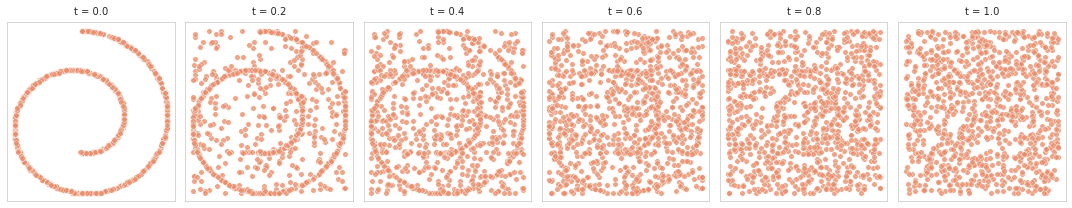

OT cost: tensor(5.1735, device='cuda:0')


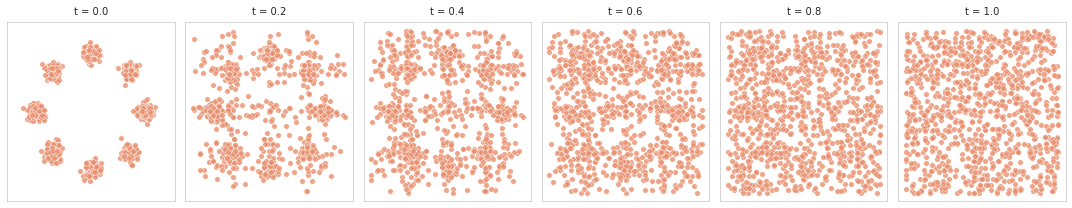

OT cost: tensor(5.0805, device='cuda:0')


In [44]:
visualize(sampler_0, model_f)
visualize(sampler_1, model_b)

In [45]:
# train_with_data(model_f, optim_f, 'f')
# train_with_data(model_b, optim_b, 'b')

In [46]:
# visualize(sampler_0, model_f)
# visualize(sampler_1, model_b)

  0%|          | 0/3 [00:00<?, ?it/s]

4.861029148101807
3.0885062217712402
2.6622824668884277
2.8751676082611084
2.785956859588623
2.4981749057769775
2.4480934143066406
2.318911075592041
2.5590217113494873
2.480377435684204


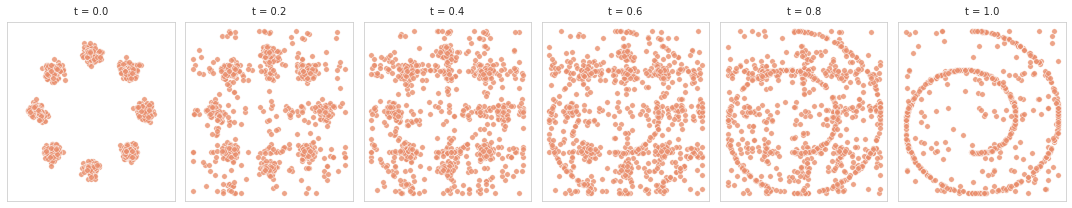

OT cost: tensor(1.4095, device='cuda:0')
4.8622283935546875
2.2495694160461426
2.1631720066070557
2.179947853088379
1.9448096752166748
2.1513924598693848
1.91921067237854
1.9231805801391602
2.1405365467071533
1.7686623334884644


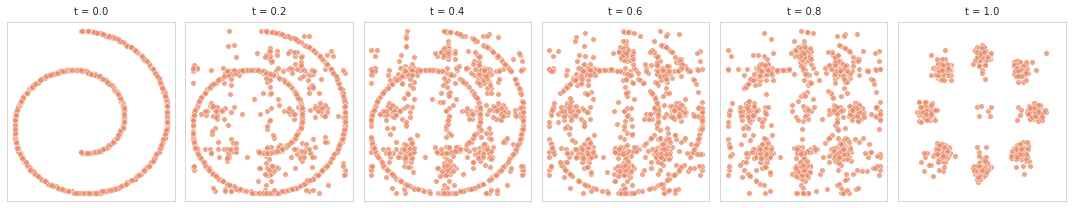

 33%|███▎      | 1/3 [03:24<06:49, 204.50s/it]

OT cost: tensor(1.1730, device='cuda:0')
2.1621973514556885
1.8772008419036865
1.8638036251068115
1.7065731287002563
2.0392587184906006
1.9863752126693726
1.9126007556915283
1.9371412992477417
1.8376882076263428
1.891261339187622


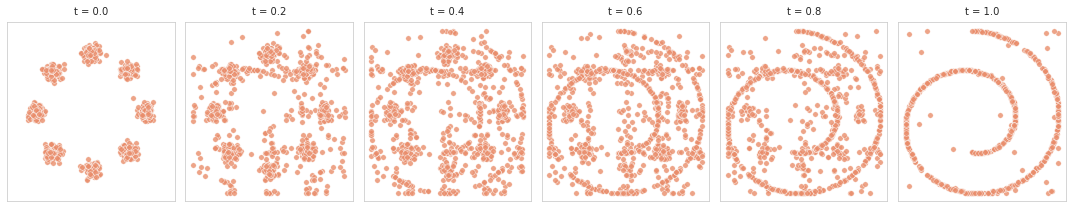

OT cost: tensor(0.9760, device='cuda:0')
1.8861057758331299
1.7785329818725586
1.782205581665039
1.728009581565857
1.9424813985824585
1.7896394729614258
1.7268232107162476
1.72189462184906
1.7978224754333496
1.7521674633026123


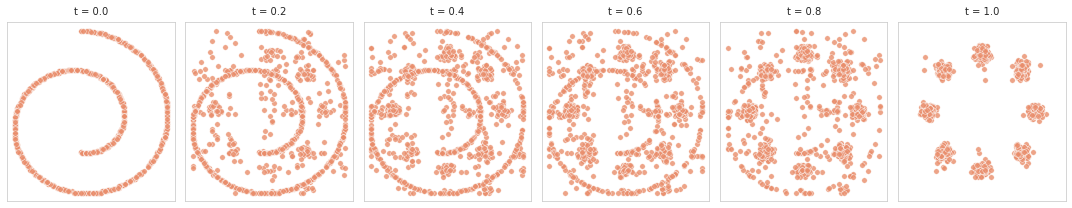

 67%|██████▋   | 2/3 [06:48<03:24, 204.10s/it]

OT cost: tensor(0.9360, device='cuda:0')
1.748998999595642
1.4942282438278198
1.7393896579742432
1.742072582244873
1.8766484260559082
1.425740361213684
1.9052611589431763
1.6416620016098022
1.7287033796310425
1.5636556148529053


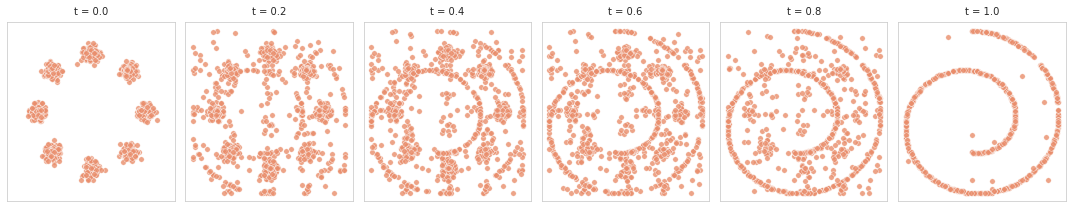

OT cost: tensor(0.8985, device='cuda:0')
1.7636876106262207
1.620944619178772
1.7466472387313843
1.7095047235488892
1.6538116931915283
1.6615718603134155
1.69515061378479
1.492281436920166
1.6405549049377441
1.5746248960494995


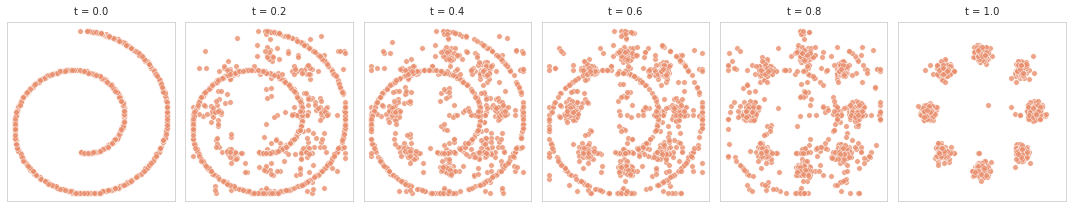

100%|██████████| 3/3 [10:14<00:00, 204.81s/it]

OT cost: tensor(0.8675, device='cuda:0')


In [47]:
for i in tqdm(range(3)):
    N = 1000
    
    train_with_model(model_b, optim_b, model_f, 'b')

    x_t = sampler_1(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
    
    x_1 = results[-1][0]
    
    visualize(sampler_1, model_b)
    
    #############################
    
    train_with_model(model_f, optim_f, model_b, 'f')

    x_t = sampler_0(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
        
    x_1 = results[-1][0]
    
    visualize(sampler_0, model_f)
    
    torch.save(model_f, 'f.pt')
    torch.save(model_b, 'b.pt')

  0%|          | 0/3 [00:00<?, ?it/s]

1.6309268474578857
1.6599147319793701
1.4047068357467651
1.6311554908752441
1.445125937461853
1.5692555904388428
1.4391590356826782
1.682535171508789
1.4037457704544067
1.2423423528671265


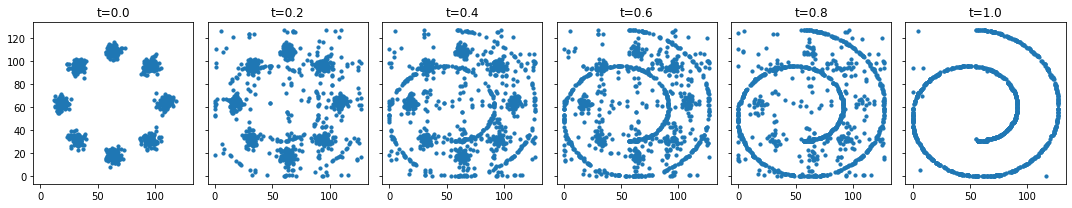

OT cost: tensor(0.8505, device='cuda:0')
1.6415448188781738
1.6707698106765747
1.5834022760391235
1.4892688989639282
1.5558702945709229
1.4848887920379639
1.5693432092666626
1.727402925491333
1.4516875743865967
1.659212350845337


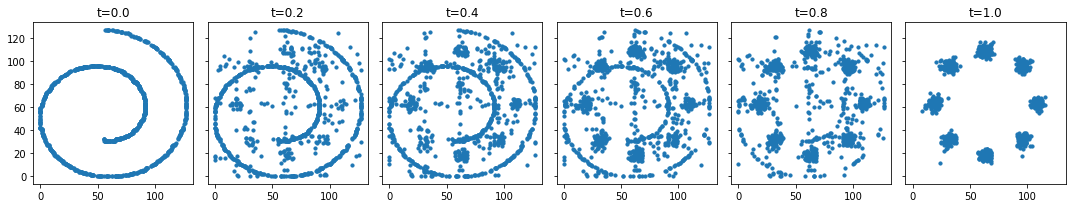

 33%|███▎      | 1/3 [04:06<08:12, 246.42s/it]

OT cost: tensor(0.8195, device='cuda:0')
1.5739378929138184
1.530283808708191
1.5384975671768188
1.3740533590316772
1.4161152839660645
1.4910532236099243
1.339516043663025
1.7439093589782715
1.3399755954742432
1.6934497356414795


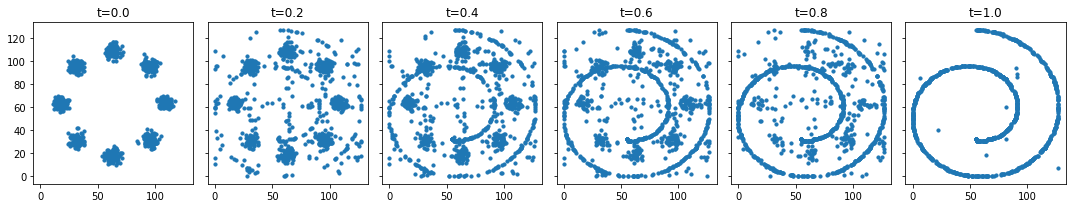

OT cost: tensor(0.8060, device='cuda:0')
1.4416862726211548
1.6557484865188599
1.5124460458755493
1.6620330810546875
1.6566908359527588
1.4927585124969482
1.5405409336090088
1.4405461549758911
1.7766081094741821
1.5920838117599487


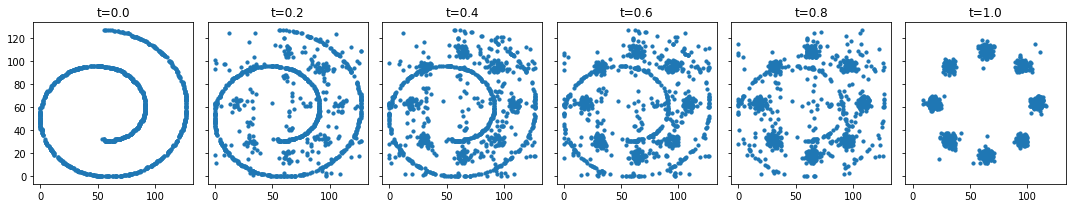

 67%|██████▋   | 2/3 [08:03<04:00, 240.81s/it]

OT cost: tensor(0.8150, device='cuda:0')
1.3986502885818481
1.4810177087783813
1.2818045616149902
1.2788869142532349
1.3216975927352905
1.4624207019805908
1.3481106758117676
1.6944609880447388
1.4355541467666626
1.4297670125961304


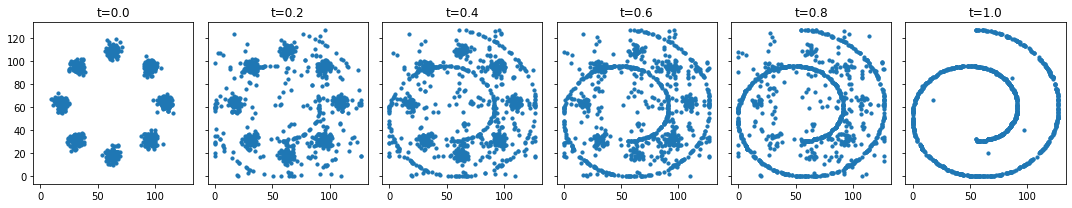

OT cost: tensor(0.8140, device='cuda:0')
1.687705397605896
1.5457589626312256
1.5110313892364502
1.6071841716766357
1.5162110328674316
1.5296381711959839
1.4509327411651611
1.636070966720581
1.444796085357666
1.5328102111816406


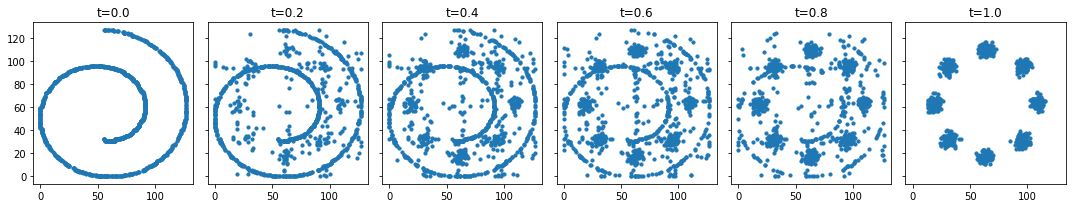

100%|██████████| 3/3 [12:07<00:00, 242.38s/it]

OT cost: tensor(0.7785, device='cuda:0')


In [32]:
for i in tqdm(range(3)):
    N = 1000
    
    train_with_model(model_b, optim_b, model_f, 'b')

    x_t = sampler_1(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
    
    x_1 = results[-1][0]
    
    visualize(sampler_1, model_b)
    
    #############################
    
    train_with_model(model_f, optim_f, model_b, 'f')

    x_t = sampler_0(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
        
    x_1 = results[-1][0]
    
    visualize(sampler_0, model_f)
    
    torch.save(model_f, 'f.pt')
    torch.save(model_b, 'b.pt')

  0%|          | 0/3 [00:00<?, ?it/s]

1.4941937923431396
1.4130738973617554
1.6442909240722656
1.413088083267212
1.2692407369613647
1.1633660793304443
1.2567116022109985
1.505597472190857
1.2854911088943481
1.217736840248108


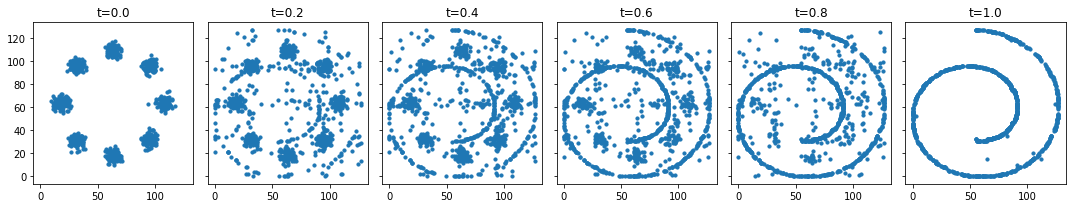

OT cost: tensor(0.8225, device='cuda:0')
1.48279869556427
1.7024773359298706
1.5840240716934204
1.5885646343231201


In [ ]:
for i in tqdm(range(3)):
    N = 1000
    
    train_with_model(model_b, optim_b, model_f, 'b')

    x_t = sampler_1(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
    
    x_1 = results[-1][0]
    
    visualize(sampler_1, model_b)
    
    #############################
    
    train_with_model(model_f, optim_f, model_b, 'f')

    x_t = sampler_0(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
        
    x_1 = results[-1][0]
    
    visualize(sampler_0, model_f)
    
    torch.save(model_f, 'f.pt')
    torch.save(model_b, 'b.pt')

  0%|          | 0/3 [00:00<?, ?it/s]

0.35816705226898193
0.555351197719574
0.5590823292732239
0.49311673641204834
0.5465719103813171
0.48996081948280334
0.5276655554771423
0.37467294931411743
0.44052955508232117
0.4092579782009125


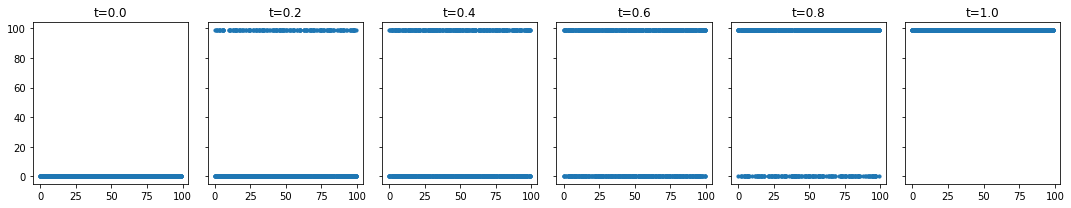

OT cost: tensor(0.6800, device='cuda:0')
0.5138665437698364
0.4102165997028351
0.49348151683807373
0.5390750765800476
0.5052721500396729
0.5264054536819458
0.6160534024238586
0.39639395475387573
0.5489482879638672
0.5239840149879456


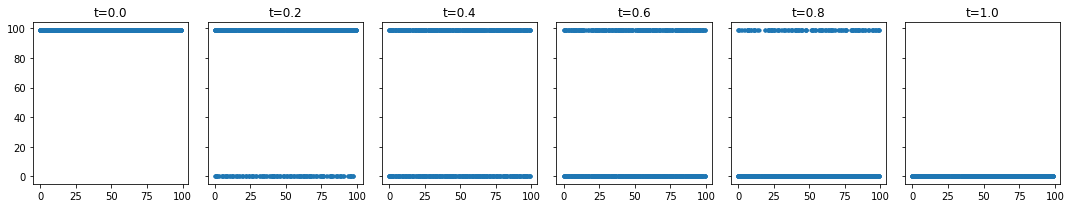

 33%|███▎      | 1/3 [03:52<07:45, 232.96s/it]

OT cost: tensor(0.6685, device='cuda:0')
0.5355857014656067
0.489423543214798
0.5019298791885376
0.6335676312446594
0.5077145099639893
0.463821679353714
0.3700524568557739
0.5774920582771301
0.5767984390258789
0.39352262020111084


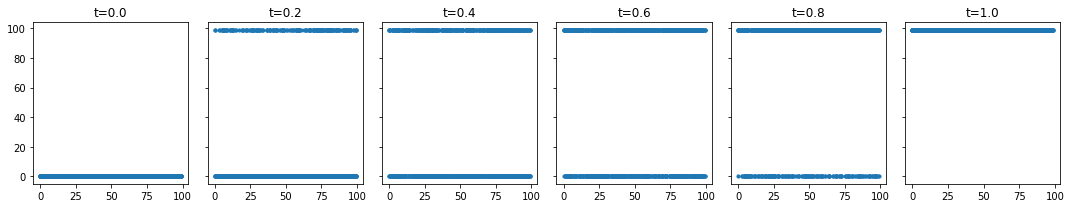

OT cost: tensor(0.6540, device='cuda:0')
0.5299108624458313
0.5186131596565247
0.3746533691883087
0.40920108556747437
0.5535644888877869
0.26920178532600403
0.47050923109054565
0.36337268352508545
0.5192070007324219
0.4706169068813324


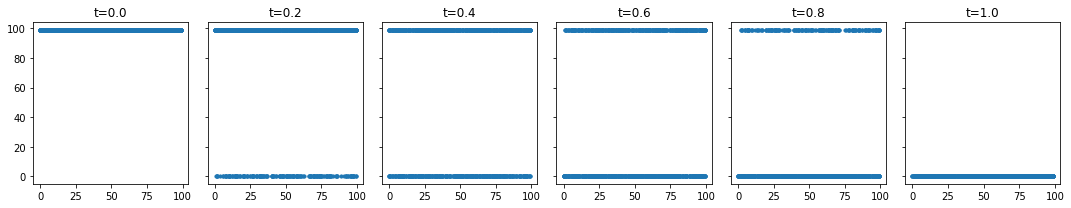

 67%|██████▋   | 2/3 [07:47<03:53, 233.63s/it]

OT cost: tensor(0.6375, device='cuda:0')
0.3421192169189453
0.3328486979007721
0.44031229615211487
0.4781661033630371
0.3208668529987335
0.3324269950389862
0.4360123872756958
0.26340726017951965
0.39756011962890625
0.45416826009750366


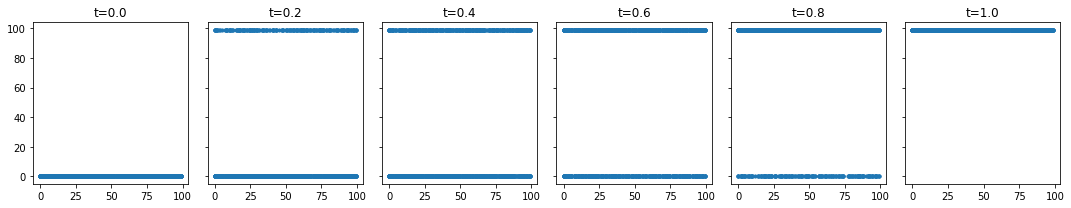

OT cost: tensor(0.6005, device='cuda:0')
0.25123074650764465
0.391861230134964
0.3597045838832855
0.5113374590873718
0.4582074284553528
0.35476282238960266
0.40738698840141296
0.4275006353855133
0.2541975975036621
0.379930704832077


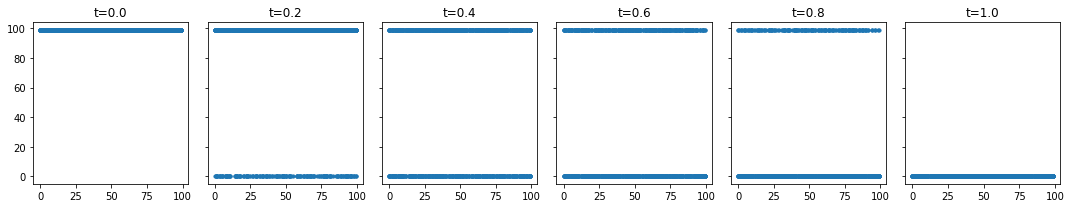

100%|██████████| 3/3 [11:40<00:00, 233.42s/it]

OT cost: tensor(0.6160, device='cuda:0')


In [33]:
for i in tqdm(range(3)):
    N = 1000
    
    train_with_model(model_b, optim_b, model_f, 'b')

    x_t = sampler_1(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
    
    x_1 = results[-1][0]
    
    visualize(sampler_1, model_b)
    
    #############################
    
    train_with_model(model_f, optim_f, model_b, 'f')

    x_t = sampler_0(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
        
    x_1 = results[-1][0]
    
    visualize(sampler_0, model_f)
    
    torch.save(model_f, 'f.pt')
    torch.save(model_b, 'b.pt')

  0%|          | 0/3 [00:00<?, ?it/s]

0.3476167321205139
0.32421553134918213
0.41239240765571594
0.3306387960910797
0.41749632358551025
0.4057011306285858
0.3957056403160095
0.3723980486392975
0.37203249335289
0.3389328718185425


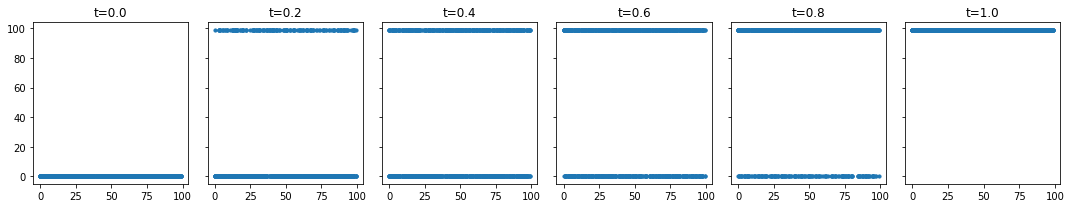

OT cost: tensor(0.5995, device='cuda:0')
0.42224758863449097
0.409415602684021
0.3293273448944092
0.3302803337574005
0.31616029143333435
0.328563392162323
0.39228546619415283
0.3676992356777191
0.3684195578098297
0.31892240047454834


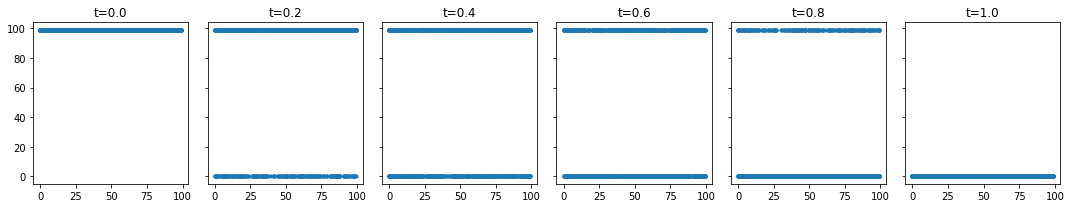

 33%|███▎      | 1/3 [03:52<07:45, 232.61s/it]

OT cost: tensor(0.6125, device='cuda:0')
0.35211262106895447
0.3617818355560303
0.3343701660633087
0.357522577047348
0.3711659014225006
0.38919076323509216
0.3778318464756012
0.3318183422088623
0.3336852788925171
0.41305845975875854


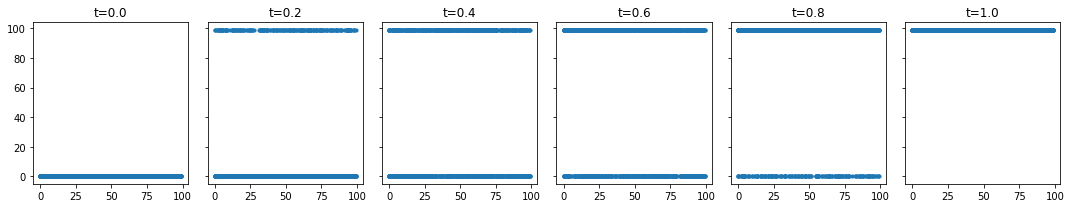

OT cost: tensor(0.6335, device='cuda:0')
0.37124377489089966
0.4323975443840027
0.3688485622406006
0.38160789012908936
0.3817642629146576
0.31709152460098267
0.3961136043071747
0.4358467161655426
0.5291262269020081
0.46779710054397583


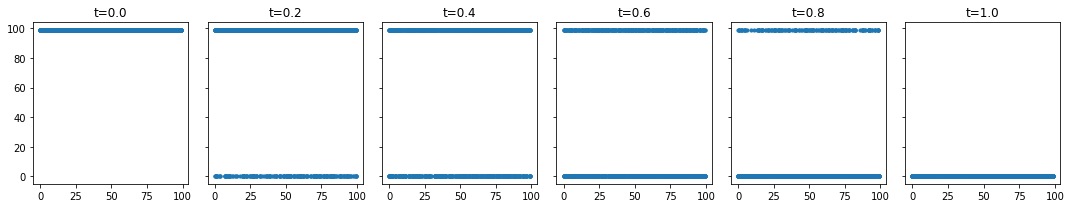

 67%|██████▋   | 2/3 [07:46<03:53, 233.44s/it]

OT cost: tensor(0.6100, device='cuda:0')
0.33126434683799744
0.3172304332256317
0.33518972992897034
0.23976339399814606
0.30144640803337097
0.33369359374046326
0.42002108693122864
0.3348724842071533
0.3797096312046051
0.2530750632286072


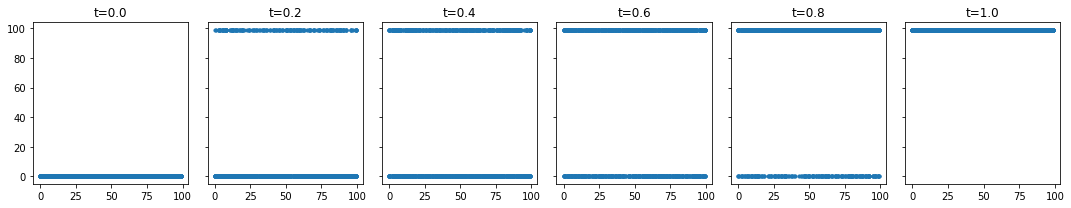

OT cost: tensor(0.5980, device='cuda:0')
0.2948009669780731
0.2509589195251465
0.24371762573719025
0.37404510378837585
0.2958206832408905
0.37365999817848206
0.23868130147457123
0.3697544038295746
0.27548280358314514
0.3866945803165436


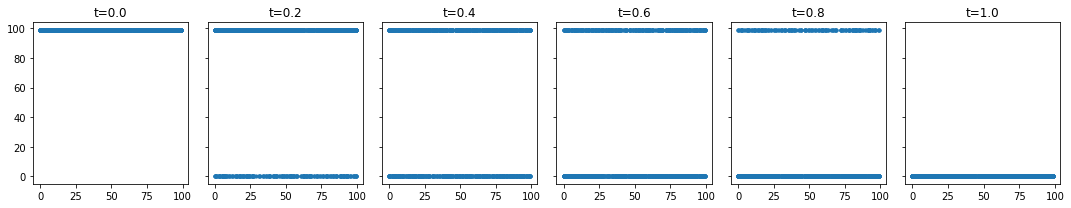

100%|██████████| 3/3 [11:39<00:00, 233.07s/it]

OT cost: tensor(0.5950, device='cuda:0')


In [37]:
for i in tqdm(range(3)):
    N = 1000
    
    train_with_model(model_b, optim_b, model_f, 'b')

    x_t = sampler_1(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
    
    x_1 = results[-1][0]
    
    visualize(sampler_1, model_b)
    
    #############################
    
    train_with_model(model_f, optim_f, model_b, 'f')

    x_t = sampler_0(N, device)
    x_0 = x_t
    t = 0.0
    results = [(x_t, t)]
    while t < 1.0 - 1e-3:
        p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * t), dim=-1)
        h = min(0.01, 1.0 - t)
        one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
        u = (p1 - one_hot_x_t) / (1.0 - t)
        x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
        t += h
        results.append((x_t, t))
        
    x_1 = results[-1][0]
    
    visualize(sampler_0, model_f)
    
    torch.save(model_f, 'f.pt')
    torch.save(model_b, 'b.pt')

In [34]:
N = 1000
x_t = sampler_1(N, device)
x_0 = x_t
t = 0.0
results = [(x_t, t)]
while t < 1.0 - 1e-3:
    p1 = torch.softmax(model_b(x_t, torch.ones(N).to(device) * t), dim=-1)
    h = min(0.01, 1.0 - t)
    one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
    u = (p1 - one_hot_x_t) / (1.0 - t)
    x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
    t += h
    results.append((x_t, t))

x_1 = results[-1][0]

In [30]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns
import torch.nn.functional as F
import torch


def plot_trajectories(x0, xT, results):  
    N_points = 50
      
    fig, axes = plt.subplots(1, 3, figsize=(15, 5.2), dpi=150, sharex=True, sharey=True, )

    
    n_steps = len(results)
    X_np = x0.cpu().numpy()

    lines = []
    for i in range(N_points):
        for j in range(n_steps-1):
            lines.append((results[j][0][i].cpu(), results[j+1][0][i].cpu()))
    lc = mc.LineCollection(lines, linewidths=0.5, color='black')
    axes[1].add_collection(lc)
    axes[1].scatter(
        X_np[:N_points, 0], X_np[:N_points, 1], c='darkseagreen', edgecolors='black',
        zorder=2)
    
    for i in range(1, n_steps-1):
        axes[1].scatter(
        results[i][0][:N_points, 0].cpu().flatten(),
        results[i][0][:N_points, 1].cpu().flatten(),
        c='blue', edgecolors='blue', zorder=1, s=1
        )
    
    axes[1].scatter(
        results[-1][0][:N_points, 0].cpu().flatten(),
        results[-1][0][:N_points, 1].cpu().flatten(),
        c='wheat', edgecolors='black', zorder=3)
    
    
    
    
    
    X_np = x0.cpu().numpy()
    T_X_np = xT.cpu().numpy()
    
    PLOT_X_SIZE = X_np.shape[0]
    
    lines = []
    for i in range(PLOT_X_SIZE):
        lines.append((X_np[i], T_X_np[i]))

    lc = mc.LineCollection(lines, linewidths=0.5, color='black')
    axes[0].add_collection(lc)
    axes[0].scatter(
        X_np[:PLOT_X_SIZE, 0], X_np[:PLOT_X_SIZE, 1], c='darkseagreen', edgecolors='black',
        zorder=2)
    axes[0].scatter(
        T_X_np[:PLOT_X_SIZE, 0].flatten(),
        T_X_np[:PLOT_X_SIZE, 1].flatten(),
        c='wheat', edgecolors='black', zorder=3)



    fig.tight_layout()
    return fig, axes

Визуализируем выученное отображение

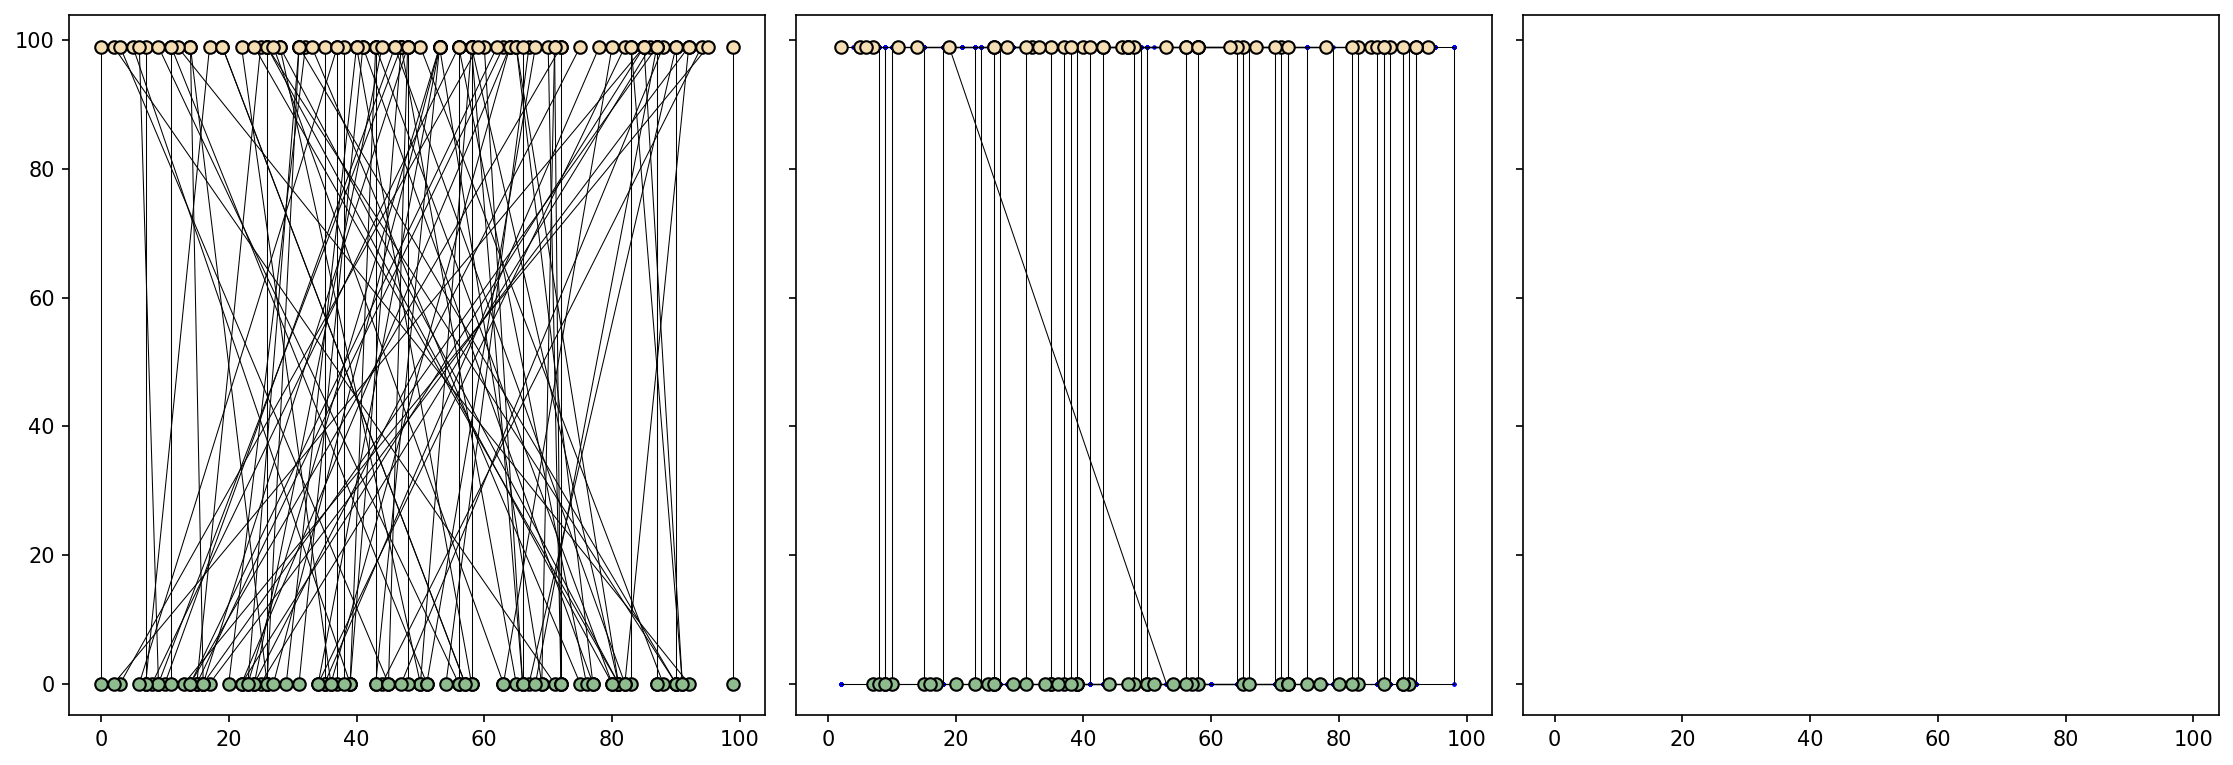

In [24]:
plot_trajectories(x_0[:100], x_1[:100], results)
None

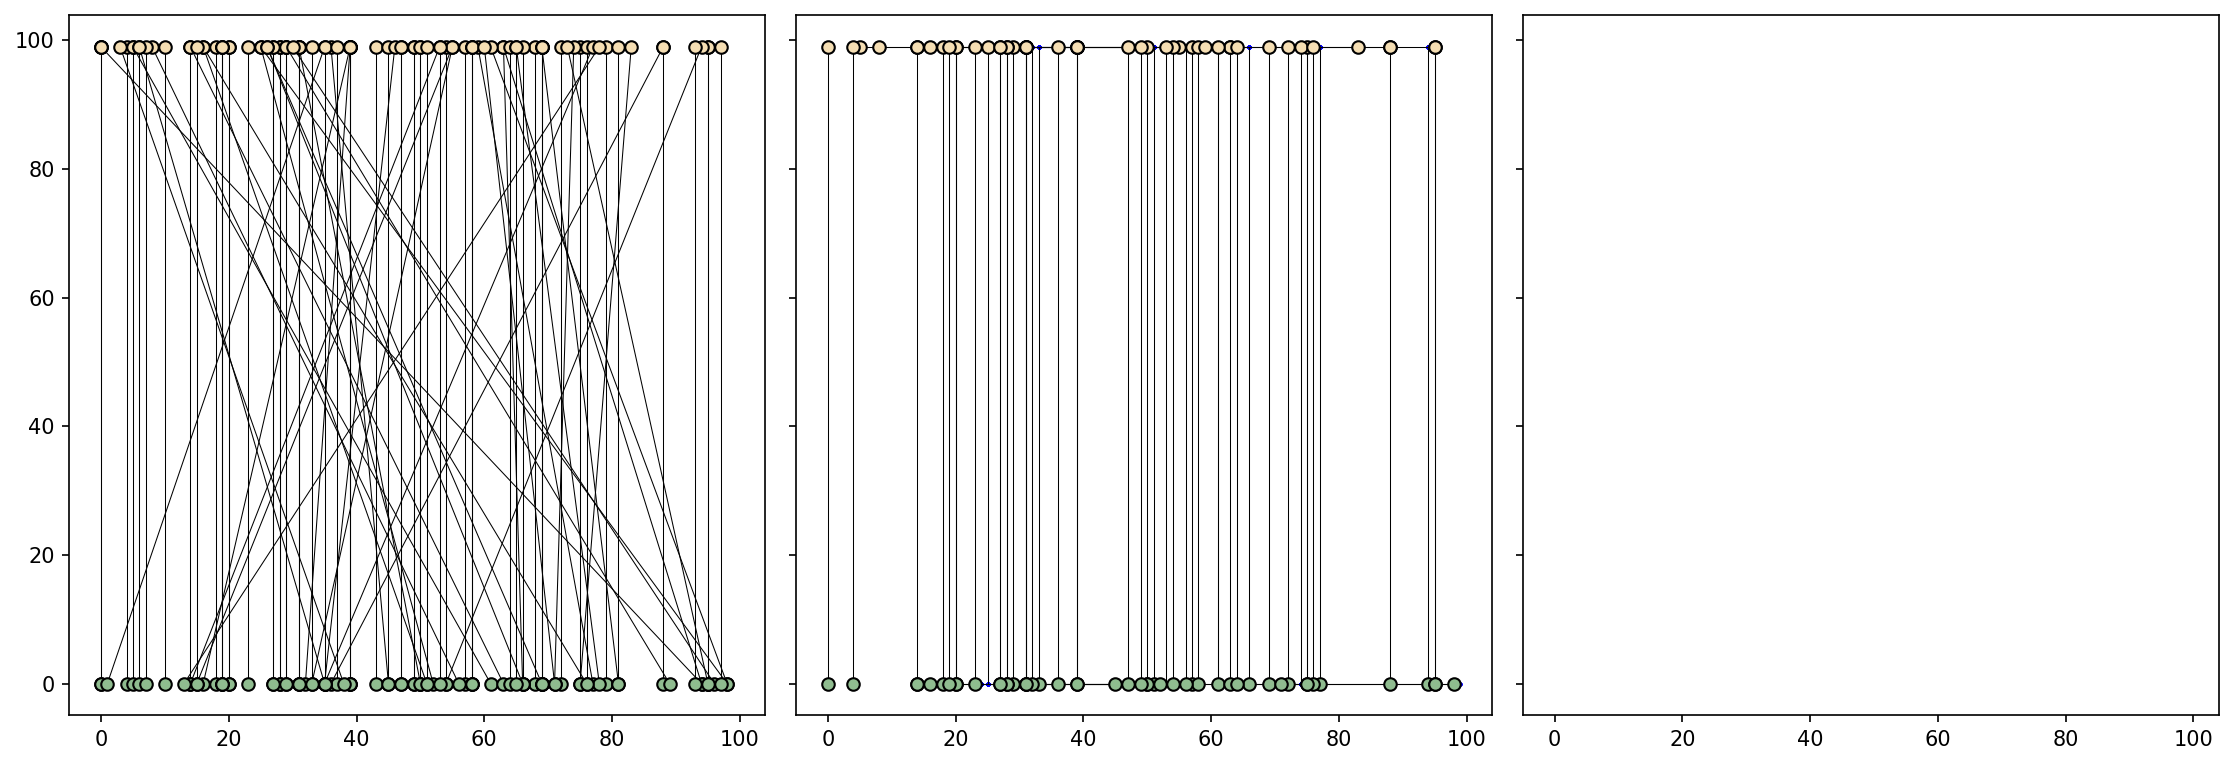

In [28]:
plot_trajectories(x_0[:100], x_1[:100], results)
None

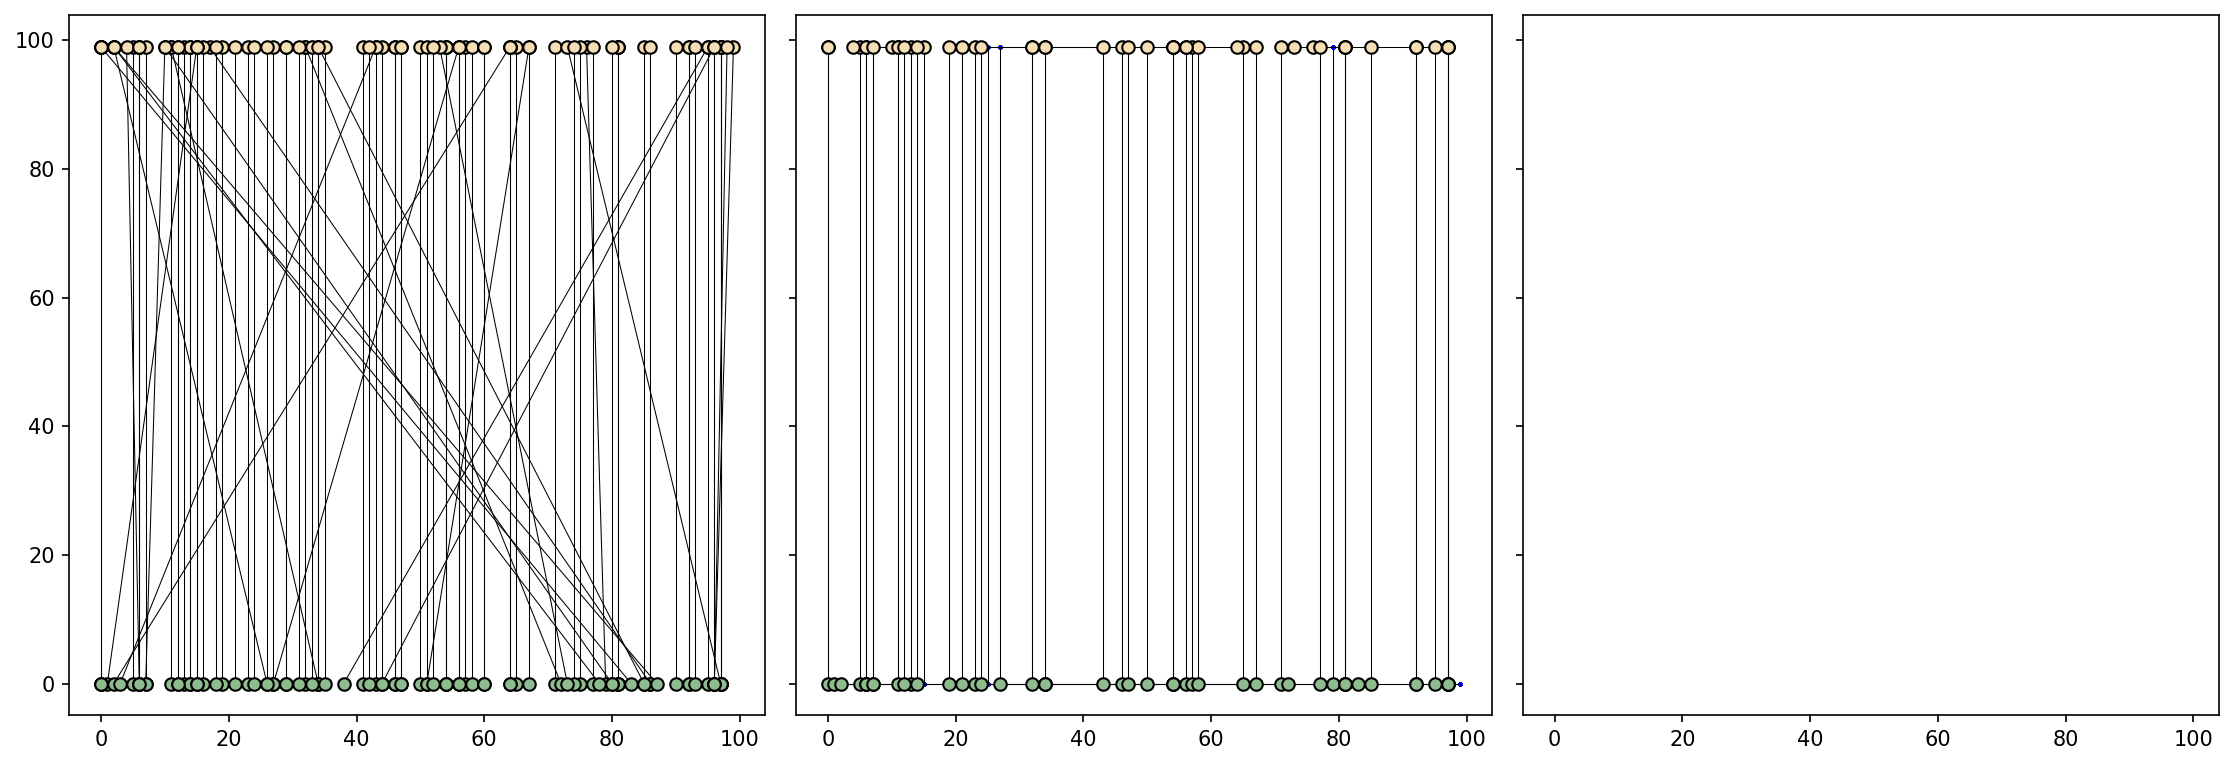

In [32]:
plot_trajectories(x_0[:100], x_1[:100], results)
None

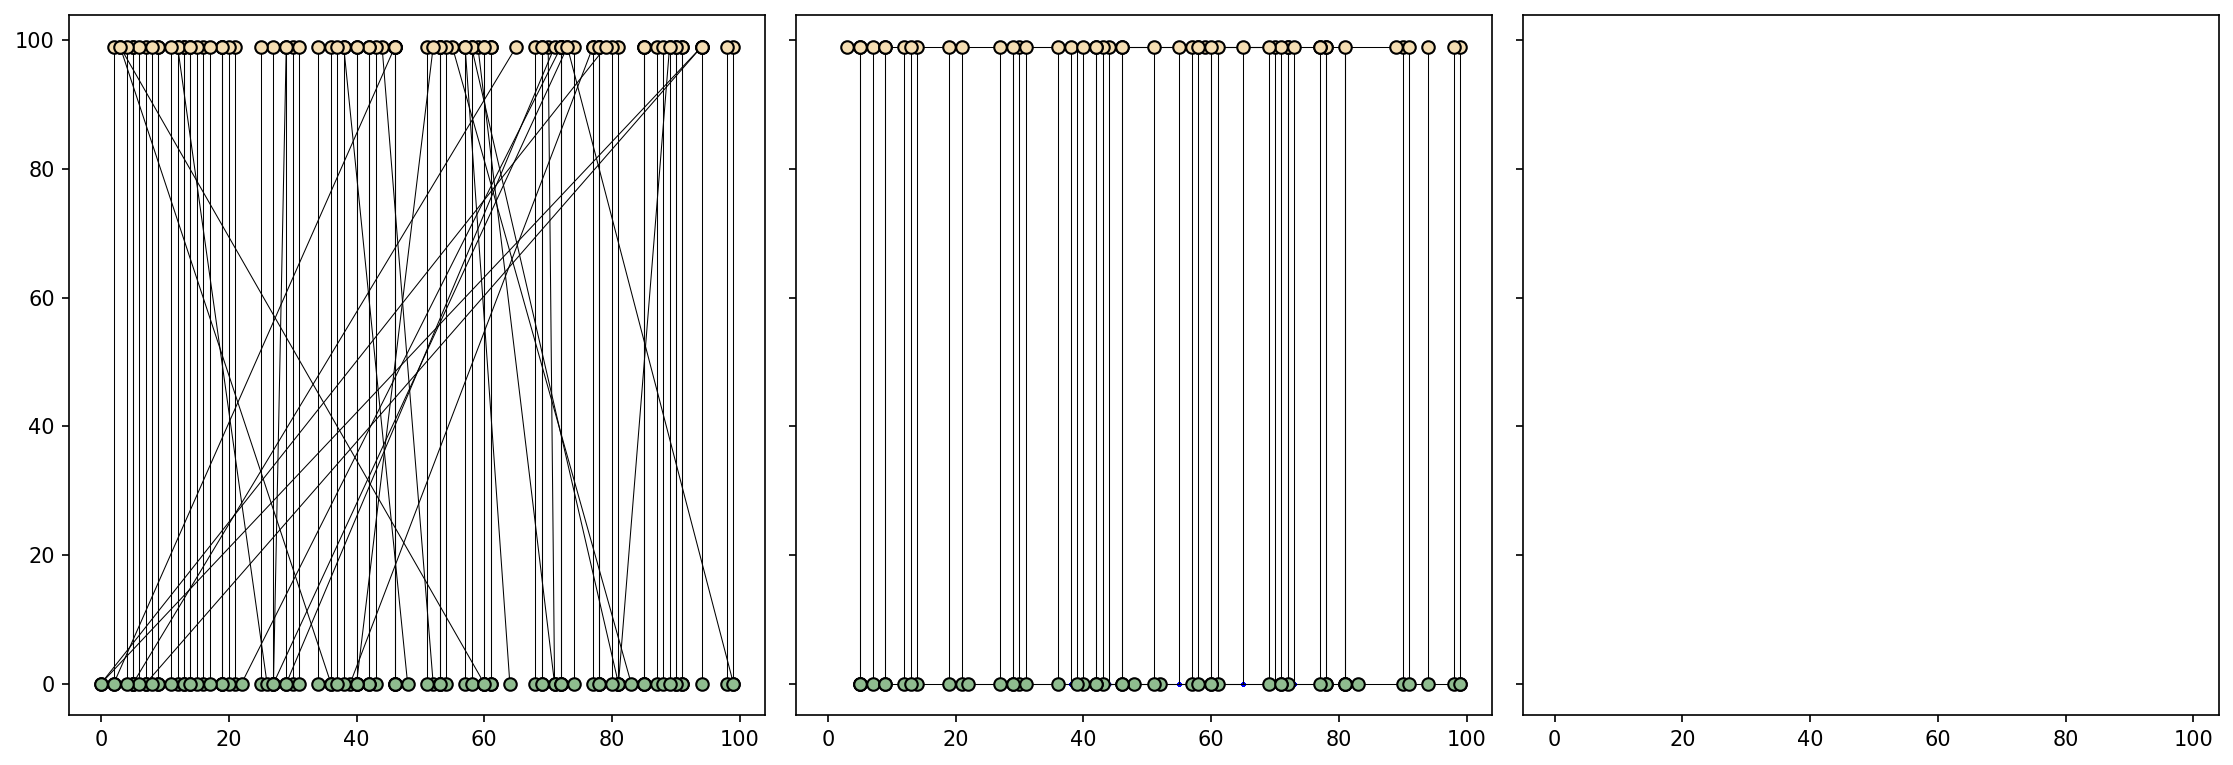

In [36]:
plot_trajectories(x_0[:100], x_1[:100], results)
None

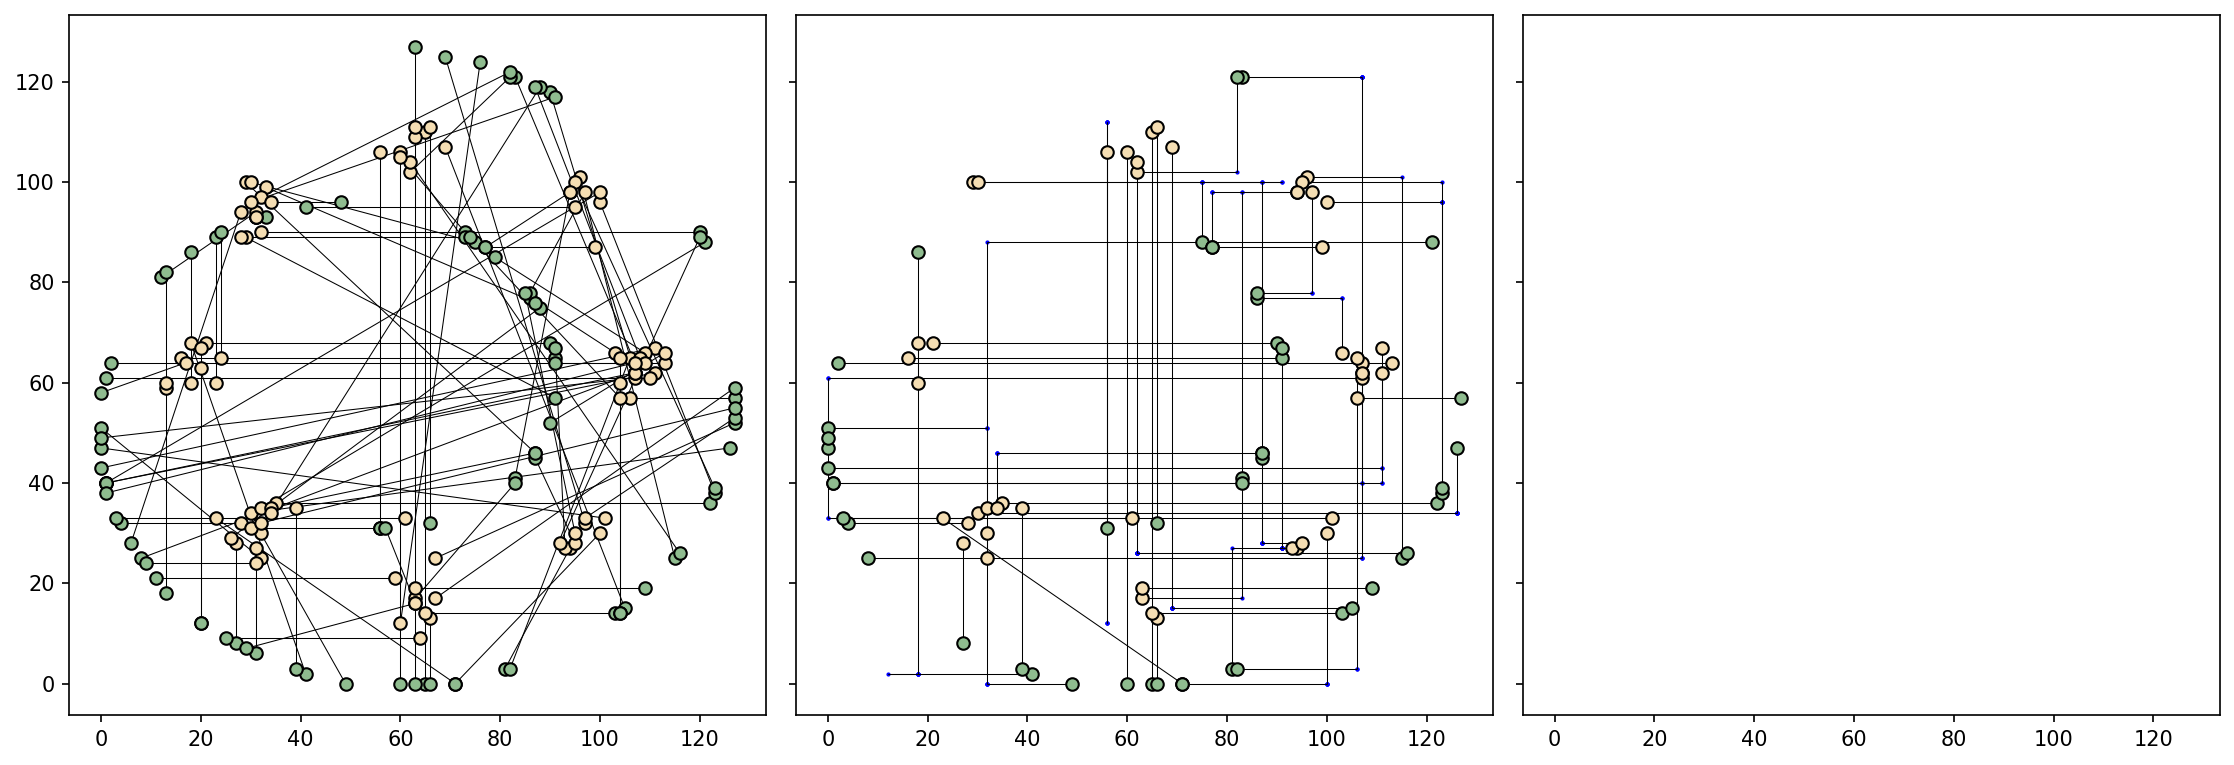

In [33]:
N = 1000
x_t = sampler_0(N, device)
x_0 = x_t
t = 0.0
results = [(x_t, t)]
while t < 1.0 - 1e-4:
    p1 = torch.softmax(model_f(x_t, torch.ones(N).to(device) * t), dim=-1)
    h = min(0.1, 1.0 - t)
    one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
    u = (p1 - one_hot_x_t) / (1.0 - t)
    x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
    t += h
    results.append((x_t, t))

x_1 = results[-1][0]

plot_trajectories(x_0[:100], x_1[:100], results)
None

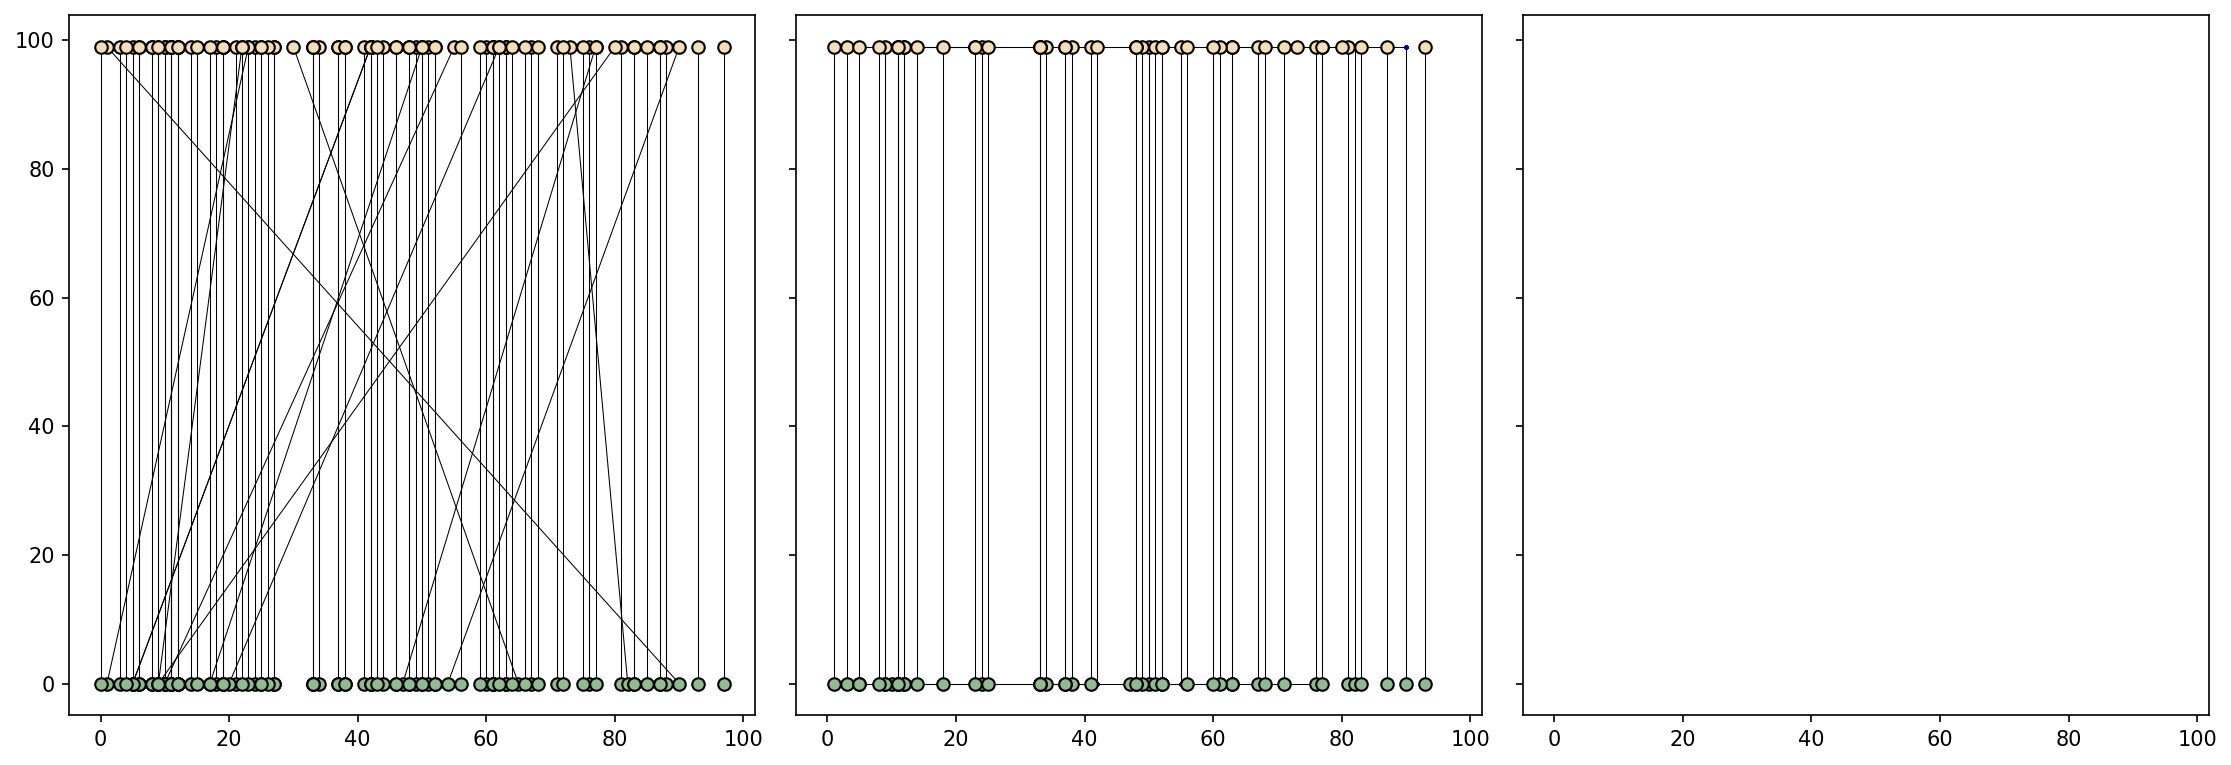

In [39]:
plot_trajectories(x_0[:100], x_1[:100], results)
None